<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/PyTorchImSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install rawpy

     |████████████████████████████████| 1.7MB 5.2MB/s 


In [3]:
import numpy as np
import os
import sys
import PIL
import PIL.Image
import glob
import rawpy
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import imageio
import scipy
import scipy.misc
import skimage.filters
import skimage.metrics
import pandas as pd
import pathlib
#import tensorflow_datasets as tfds
from keras_preprocessing import image
try:
  from scipy import linalg  # pylint: disable=unused-import
  from scipy import ndimage  # pylint: disable=unused-import
except ImportError:
  pass

In [4]:
cd 'drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection'

/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection


In [6]:
print(tf.__version__)
os.getcwd()

2.4.1


'/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection'

In [5]:
data_gen_def = tf.keras.preprocessing.image.ImageDataGenerator()

list1 = tf.keras.preprocessing.image.DirectoryIterator(os.getcwd(), data_gen_def)

Found 0 images belonging to 0 classes.


In [5]:
image1 = tf.io.decode_raw(glob.glob('*.dng')[0], tf.int32)
raw_height = tf.cast(example['image/height'], tf.int32)
raw_width = tf.cast(example['image/width'], tf.int32)
image = tf.reshape(image, [raw_height, raw_width, 3])
image = tf.image.resize_images(image, size=[self.height, self.width])

In [6]:
print(image1)

tf.Tensor([ 829711731 1831874655 1735287854], shape=(3,), dtype=int32)


TypeError: ignored

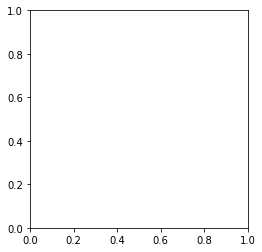

In [12]:
plt.imshow(tf.shape( tf.squeeze(image1)))


In [8]:
image_list = []

#for image in os.listdir():
#    print(image)

image_list = []
for filename in glob.glob('*.dng'): 
    im=rawpy.imread(filename)
    image_list.append(im)

In [97]:
imageio.plugins.freeimage.download()

sc_im = imageio.imread(glob.glob('*.dng')[0], format='RAW-FI')

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)1392640/4830080 bytes (28.8%)3809280/4830080 bytes (78.9%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


In [98]:
type(sc_im)

imageio.core.util.Array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


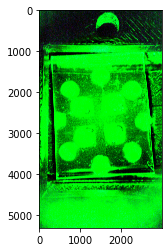

In [99]:
plt.imshow(sc_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


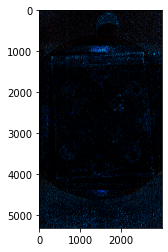

In [102]:
sc_tes_median = scipy.ndimage.median_filter(sc_im, size=3)
plt.imshow(sc_tes_median, cmap='brg')

Text(0, 0.5, 'Count')

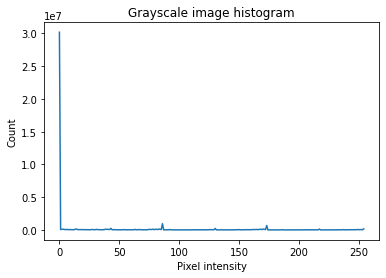

In [103]:
counts, vals = np.histogram(sc_im, bins=range(2 ** 8))
plt.plot(range(0, (2 ** 8) - 1), counts)
plt.title('Grayscale image histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Count')

In [ ]:
#from google.colab.patches import cv2_imshow
#blue, green, red = cv2.split(sc_im)

#cv2_imshow(blue)
#cv2_imshow(red)
#cv2_imshow(green)

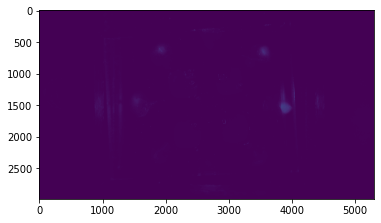

In [9]:
plt.imshow(image_list[0].raw_image)

In [101]:
print(glob.glob("*/*dng"))

['zero_min/set7_00m.dng', 'zero_min/set10_00m.dng', 'zero_min/set12_00m.dng', 'zero_min/set4_00m.dng', 'zero_min/set1_00m.dng', 'zero_min/set11_00m.dng', 'zero_min/set3_00m.dng', 'zero_min/set2_00m.dng', 'zero_min/set8_00m.dng', 'zero_min/set9_00m.dng', 'zero_min/set6_00m.dng', 'zero_min/set5_00m.dng', 'sixty_min/set12_61m.dng', 'sixty_min/set10_61m.dng', 'sixty_min/set1_61m.dng', 'sixty_min/set3_61m.dng', 'sixty_min/set2_61m.dng', 'sixty_min/set11_61m.dng', 'sixty_min/set4_61m.dng', 'sixty_min/set8_61m.dng', 'sixty_min/set9_61m.dng', 'sixty_min/set7_61m.dng', 'sixty_min/set6_61m.dng', 'sixty_min/set5_61m.dng']


In [83]:
#Visualizing the raw image doesn't seem too helpful. The image can be postprocessed,
#but I am unsure if there are undesirable effects of that. 
#However, as long as the same process is applied to each image, that equalizes
#some of the side effects.
#This Stackoverflow Q&A has some information to consider related to the topic.
#https://stackoverflow.com/questions/49459630/rawpy-how-to-postprocess-raw-images-without-adulterating-pixel-data
#image.postprocess(gamma=(1,1), no_auto_bright=True, output_bps=16)

postpro_list = []
for image in image_list: 
    postpro_list.append(image.postprocess(use_camera_wb=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


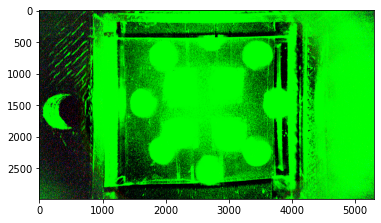

In [92]:
test_postpro = image_list[0].postprocess(gamma=(1,1), no_auto_bright=True, output_bps=16)
plt.imshow(test_postpro)

(-0.5, 5311.5, 2987.5, -0.5)

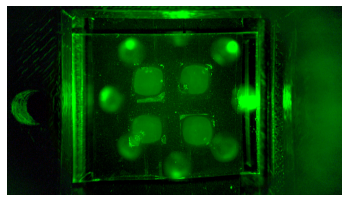

In [93]:
plt.subplot(1, 1, 1)
plt.imshow(postpro_list[0], cmap='brg')
plt.axis('off')

(-0.5, 2987.5, 5311.5, -0.5)

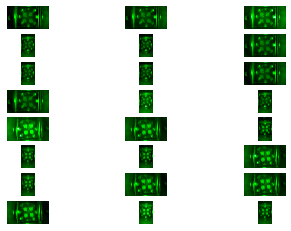

In [91]:
plt.subplot(8, 3, 1)
plt.imshow(postpro_list[0], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 2)
plt.imshow(postpro_list[1], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 3)
plt.imshow(postpro_list[2], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 4)
plt.imshow(postpro_list[3], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 5)
plt.imshow(postpro_list[4], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 6)
plt.imshow(postpro_list[5], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 7)
plt.imshow(postpro_list[6], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 8)
plt.imshow(postpro_list[7], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 9)
plt.imshow(postpro_list[8], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 10)
plt.imshow(postpro_list[9], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 11)
plt.imshow(postpro_list[10], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 12)
plt.imshow(postpro_list[11], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 13)
plt.imshow(postpro_list[12], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 14)
plt.imshow(postpro_list[13], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 15)
plt.imshow(postpro_list[14], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 16)
plt.imshow(postpro_list[15], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 17)
plt.imshow(postpro_list[16], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 18)
plt.imshow(postpro_list[17], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 19)
plt.imshow(postpro_list[18], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 20)
plt.imshow(postpro_list[19], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 21)
plt.imshow(postpro_list[20], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 22)
plt.imshow(postpro_list[21], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 23)
plt.imshow(postpro_list[22], cmap='brg')
plt.axis('off')
plt.subplot(8, 3, 24)
plt.imshow(postpro_list[23], cmap='brg')
plt.axis('off')

In [36]:
#This is for keras.preprocessing.image...
img_width = 186
img_height = 332
batch_size = 6

In [ ]:
#Keras/TF won't work with .dng/RAW files
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [78]:
median_filtered = scipy.ndimage.median_filter(image01_rgb, size=3)

NameError: ignored

=====================================================================

This is initial code for image segmentation of LAMP assay images. The code is based on a [PyTorch tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
import os
import sys

'/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set1'

In [ ]:
cd 'drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John'

[Errno 2] No such file or directory: 'drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John'
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set1


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMEMP5S/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMEMP5S/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
os.listdir()

image_data_set = []

data_names = []

for i in os.listdir():
  for j in os.listdir(i):
    print(os.path.join( os.getcwd(), i, j))

/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set1/set1_61m.dng
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set1/set1_00m.dng
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set3/set3_61m.dng
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set3/set3_00m.dng
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set2/set2_61m.dng
/content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/Set2/set2_00m.dn

In [ ]:
import os
import sys

walk_dir = os.getcwd()

print('walk_dir = ' + walk_dir)

# If your current working directory may change during script execution, it's recommended to
# immediately convert program arguments to an absolute path. Then the variable root below will
# be an absolute path as well. Example:
# walk_dir = os.path.abspath(walk_dir)
print('walk_dir (absolute) = ' + os.path.abspath(walk_dir))

for root, subdirs, files in os.walk(walk_dir):
    print('--\nroot = ' + root)
    list_file_path = os.path.join(root, 'my-directory-list.txt')
    print('list_file_path = ' + list_file_path)

    with open(list_file_path, 'wb') as list_file:
        for subdir in subdirs:
            print('\t- subdirectory ' + subdir)

        for filename in files:
            file_path = os.path.join(root, filename)

            print('\t- file %s (full path: %s)' % (filename, file_path))

            with open(file_path, 'rb') as f:
                f_content = f.read()
                list_file.write(('The file %s contains:\n' % filename).encode('utf-8'))
                list_file.write(f_content)
                list_file.write(b'\n')

walk_dir = /content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John
walk_dir (absolute) = /content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John
--
root = /content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John
list_file_path = /content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5QhufEXgNX_wbZVfg/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/my-directory-list.txt
	- subdirectory Set1
	- subdirectory Set3
	- subdirectory Set2
	- subdirectory Set4
	- subdirectory Set5
	- subdirectory Set6
	- subdirectory set7
	- subdirectory set8
	- subdirectory set9
	- subdirectory set10
	- subdirectory set11
	- subdirectory set12
--
root = /content/drive/.shortcut-targets-by-id/1-5I4VO21o4cSUAm5Q

In [ ]:
im1 = rawpy.imread(os.listdir(os.path.join(os.getcwd(), os.listdir()[0]))[1])

NameError: ignored

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
type(train)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Mask', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

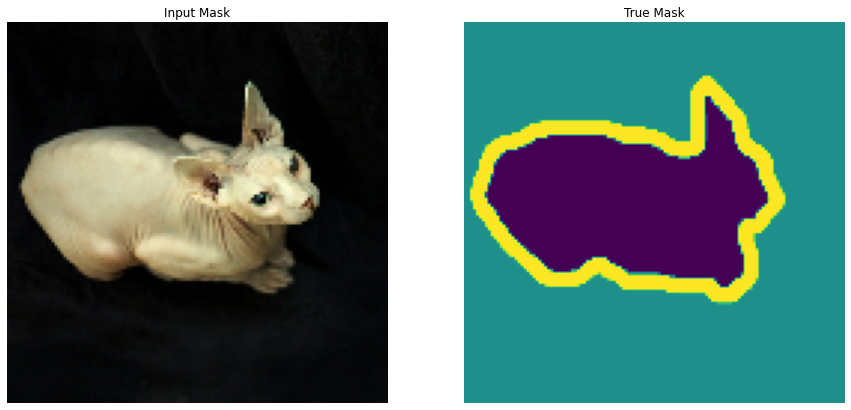

In [ ]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu', 
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [ 
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [ ]:
def unet_model(output)